# Data Preprocessing

In [714]:
import pandas as pd

In [680]:
training_data = pd.DataFrame.from_csv('train.csv')
test_data = pd.DataFrame.from_csv('test.csv')

df = pd.concat([training_data, test_data])
training_starting_idx = 0
training_ending_idx = len(training_data)

target = 'SalePrice'
features = [feature for feature in df.columns if feature != target]

Handling missing values

In [681]:
missing_values_stats = df.isnull().sum()

In [682]:
missing_values_stats[missing_values_stats!=0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

dropping features which have too many missing values

In [683]:
drop_columns = [col for col in features if df[col].isnull().sum() > 1000]
df.drop(drop_columns, 1, inplace=True)

In [684]:
features = list(filter(lambda x: x not in drop_columns, features))

In [685]:
numerical_features = []
categorical_features = []
for var in features:
    if 1. * df[training_starting_idx: training_ending_idx][var].nunique() / df[training_starting_idx: training_ending_idx][var].count() < 0.05:
        categorical_features.append(var)
        df[var] = df[var].astype('category')
    else:
        numerical_features.append(var)
        df[var] = df[var].astype(float)

In [686]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df[training_starting_idx: training_ending_idx][numerical_features])
df[numerical_features] = imr.transform(df[numerical_features].values)

In [687]:
for var in categorical_features:
    df[var] = df[var].fillna(df[training_starting_idx: training_ending_idx][var].value_counts().idxmax())

In [688]:
assert df[features].isnull().sum().sum() == 0

Handling categorical variables

In [689]:
df = pd.get_dummies(df)

Handling skewness

In [690]:
from scipy.stats import skew

In [691]:
skewed_feats = df[numerical_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [692]:
df[skewed_feats] = np.log1p(df[skewed_feats])

Scaling numerical features

In [693]:
from sklearn.preprocessing import StandardScaler

In [694]:
stdsc = StandardScaler()

In [695]:
stdsc.fit(df[training_starting_idx: training_ending_idx][numerical_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [696]:
df[numerical_features] = stdsc.transform(df[numerical_features])

# Fit a Lasso model

In [697]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [699]:
training_features = list(filter(lambda x: x != 'SalePrice', df.columns))

In [700]:
train_X = df[training_starting_idx: training_ending_idx][training_features]
train_Y = np.log1p(df[training_starting_idx: training_ending_idx]['SalePrice'])

In [701]:
model_lasso = LassoCV(alphas = [100, 10, 1, 0.1, 0.001, 0.0005], max_iter=100000).fit(train_X, train_Y)

# Model evaluation

taking a look at the selected features

In [708]:
coef = pd.Series(model_lasso.coef_, index = training_features)

In [710]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 150 variables and eliminated the other 385 variables


In [723]:
imp_coef = pd.concat([coef.sort_values().head(15),
                      coef.sort_values().tail(15)])

In [724]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

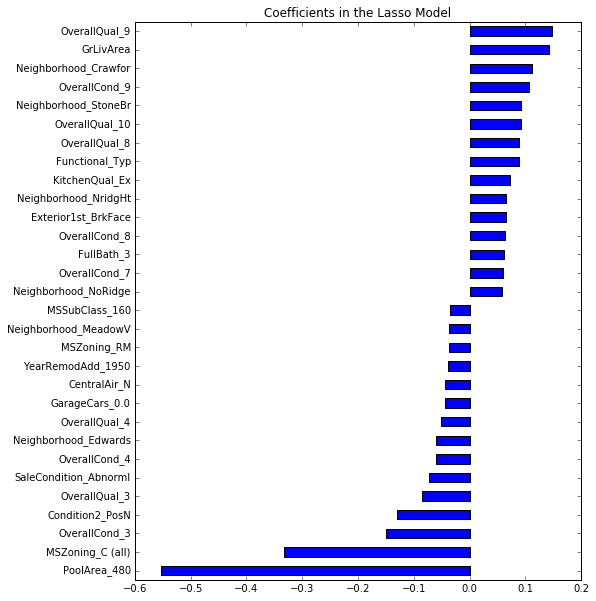

In [725]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [726]:
model_lasso.score(train_X, train_Y)

0.93196774266827853

In [702]:
test_X = df[training_ending_idx:][training_features]

In [703]:
predictions = np.exp(model_lasso.predict(test_X))-1

In [704]:
predictions = pd.Series(predictions, index=range(training_ending_idx+1, training_ending_idx+1+len(test_X)))

In [705]:
predictions.to_csv('better_lasso.csv')